### Importing Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras

In [2]:
import pickle

def load_set(directory):
    try:
        with open(f"{directory}/texts.pkl", "rb") as fp:
            processed_texts = pickle.load(fp)
        
        with open(f"{directory}/labels.pkl", "rb") as fp:
            labels = pickle.load(fp)
    
    except:
        print(f'{directory} files not found. Please run the preprocess.ipynb before!')
    
    return processed_texts, labels

In [3]:
processed_texts, labels = load_set('train')
processed_val_texts, val_labels = load_set('val')
processed_test_texts, test_labels = load_set('test')

In [4]:
processed_texts[:5]

['need advice appreciate people will will super aggressive control 6 month ago cheat girlfriend tell shortly feel like shit remind come get bad want stay thought linger way closure come thank advance hope y’ hate',
 'dear Magic Eye Bot hate wanna T',
 'teacher sub right wrong answer assignment clearly personal choice',
 'officially close 30 year age 10 goodbye r teenager fun today reach age subreddit long target good thing care cause mind 12',
 'sure royal family racism thing interesting you hear conspiracy kidnap child own cult shit wild surprised queen live']

In [5]:
lengths = [len(processed_text) for processed_text in processed_texts if len(processed_text) < 2000]

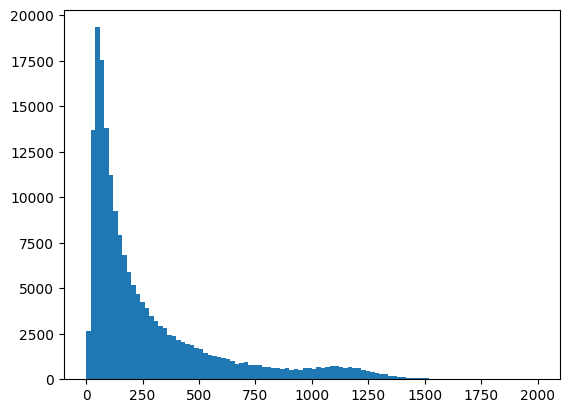

In [6]:
plt.hist(lengths, bins=100)
plt.show()

### Creating the Model

#### Vectorization

In [7]:
TextVectorization = keras.layers.TextVectorization

vectorize_layer = TextVectorization(
    max_tokens=3000,
    output_mode='int',
    output_sequence_length=200,
)

vectorize_layer.adapt(processed_texts + processed_val_texts)

In [8]:
vectorized_texts = vectorize_layer(processed_texts)

In [9]:
vectorized_val_texts = vectorize_layer(processed_val_texts)

#### Model 1

In [10]:
from keras_tuner import HyperParameters as hp
Sequential = keras.models.Sequential

model = Sequential([
    keras.layers.Embedding(3001, 16),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.LSTM(20),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [11]:
model.fit(vectorized_texts, labels, epochs=10, validation_data=(vectorized_val_texts, val_labels), callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ])

Epoch 1/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 177s 30ms/step - accuracy: 0.5089 - loss: 0.6918 - val_accuracy: 0.8683 - val_loss: 0.3569
Epoch 2/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 173s 30ms/step - accuracy: 0.9153 - loss: 0.2270 - val_accuracy: 0.9371 - val_loss: 0.1709
Epoch 3/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 172s 30ms/step - accuracy: 0.9415 - loss: 0.1569 - val_accuracy: 0.9373 - val_loss: 0.1652
Epoch 4/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 172s 30ms/step - accuracy: 0.9463 - loss: 0.1431 - val_accuracy: 0.9382 - val_loss: 0.1610
Epoch 5/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 173s 30ms/step - accuracy: 0.9489 - loss: 0.1361 - val_accuracy: 0.9392 - val_loss: 0.1613
Epoch 6/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 171s 30ms/step - accuracy: 0.9508 - loss: 0.1301 - val_accuracy: 0.9380 - val_loss: 0.1707
Epoch 7/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 172s 30ms/step - accuracy: 0.9536 - loss: 0.1253 - val_accuracy: 0.9373 - val_loss: 0.1635
Epoch 8/10
5802/5802 ━━━━━━━━━━━━━━━━━━━━ 171s 29ms/step - accuracy: 

##### Evaluating the Model

In [12]:
vectorized_test_texts = vectorize_layer(processed_test_texts)

#### Saving the Model

In [13]:
best_model = model
with open('../models/lstm_last.pkl', 'wb') as fp:
    pickle.dump(model, fp)

In [14]:
best_model.summary()
_ = best_model.evaluate(vectorized_test_texts, test_labels)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 16)        │        48,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 200, 20)        │         2,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,833 (636.07 KB)

 Trainable params: 54,277 (212.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 108,556 (424.05 KB)

726/726 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9369 - loss: 0.1755


In [15]:
y_pred = best_model.predict(vectorized_test_texts)
y_pred = (y_pred > 0.5).astype(int)
y_pred = np.array(list(map(lambda x: x[0], y_pred)))

726/726 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

print(f'accuracy_score {accuracy_score(test_labels, y_pred):.3f}')
print(f'precision_score {precision_score(test_labels, y_pred):.3f}')
print(f'recall_score {recall_score(test_labels, y_pred):.3f}')
print(f'f1_score {f1_score(test_labels, y_pred):.3f}')

False Positive Rate: 0.0778
False Negative Rate: 0.0483
accuracy_score 0.937
precision_score 0.923
recall_score 0.952
f1_score 0.937


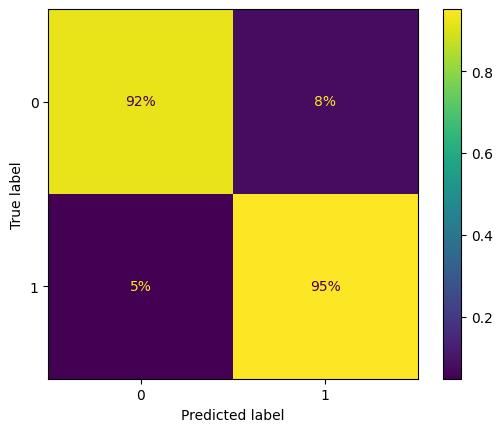

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()